# Imports

In [1]:
ORIGIN_DATASET_FOLDER = "/content/drive/MyDrive/DeepLearningProject"

In [2]:
import os
import time
import datetime
import shutil
import pprint

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

from collections import defaultdict

In [3]:
import random
from random import randrange
from tqdm.notebook import tqdm

In [4]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import models

In [5]:
from sklearn.cluster import MiniBatchKMeans

In [6]:
!pip install transformers
import transformers

     |████████████████████████████████| 3.5 MB 12.7 MB/s 
     |████████████████████████████████| 67 kB 1.9 MB/s 
     |████████████████████████████████| 895 kB 50.9 MB/s 
     |████████████████████████████████| 6.8 MB 45.0 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
def get_device():
    if torch.cuda.device_count() == 0:
        return 'cpu'
    else:
        return 'cuda'

# Templates

In [8]:
class Metrics(object):
    """
    STATIC collection of utility methods to compute metrics over a model's 
    confusion dictionary
    """ 

    @staticmethod
    def accuracy(conf_dict):
        """
        Returns a dict with all attributes accuracy, plus the total one (average).
        """
        results = {}
        for k in conf_dict:
            results[k] = conf_dict[k].trace() / conf_dict[k].sum()
        results['global'] = np.mean(list(results.values())).item()
        return results
    
    @staticmethod
    def precision(conf_dict, avg=False):
        # TP / (TP + FP)
        results = {}
        lbs = get_texted_labels()
        for k in conf_dict:
            results[k] = {}
            for i, k_name in enumerate(lbs[k]):
                denominator = conf_dict[k][:, i].sum()
                if denominator == 0:
                    results[k][k_name] = 0
                else:
                    results[k][k_name] = conf_dict[k][i,i] / denominator
            if avg:
                results[k] = np.mean(list(results[k].values()))
        if avg:
            results['global'] = np.mean(list(results.values())).item()
        return results

    """
    Example of how we compute recall for 2d attributes
        [0,1] ---> (0 / (0+1))
        [2,3] ---> (3 / (2+3)) 
        -----------------
        if avg:    (0 / (0+1)) +
                   (3 / (2+3))  
                    /2
    """
    
    @staticmethod
    def recall(conf_dict,  avg=False):
        # TP / (TP + FN)
        results = {}
        lbs = get_texted_labels()
        for k in conf_dict:
            results[k] = {}
            for i, k_name in enumerate(lbs[k]):
                results[k][k_name] = conf_dict[k][i,i] / conf_dict[k][i].sum()
            if avg:
                results[k] = np.mean(list(results[k].values()))
        if avg:
            results['global'] = np.mean(list(results.values())).item()
        return results
    
    @staticmethod
    def f1(conf_dict):
        # (2 * precision * recall) / (precision + recall)
        results = {}
        prec = Metrics.precision(conf_dict, avg=True)
        rec = Metrics.recall(conf_dict, avg=True)
        for k in conf_dict:
            denominator = prec[k] + rec[k]
            if denominator == 0:
                results[k] = 0
            else:
                results[k] = 2*prec[k]*rec[k] / denominator
        results['global'] = np.mean(list(results.values())).item()
        return results

In [9]:
def iterate(model, dataloader, optimizer, lr_scheduler, loss_fn, mode):
    if mode == 'train': 
        model.train()
        loss_fn.train()
    else: 
        model.eval()
        loss_fn.eval()

    loss_history = torch.zeros(len(dataloader), dtype=torch.float)
    
    # Init progressbar
    progbar_length = len(dataloader)
    progbar = tqdm(position=0, leave=True)
    progbar.reset(total=progbar_length)

    if mode == 'train': 
        for i, data in enumerate(dataloader):
            optimizer.zero_grad()
            loss = model.process_batch(data, loss_fn)
            loss.backward()
            optimizer.step()
            if lr_scheduler is not None: lr_scheduler.step()
            progbar.update()
            
            loss_history[i] = loss
    else:
        with torch.no_grad():
            for i, data in enumerate(dataloader):
                loss = model.process_batch(data, loss_fn)
                progbar.update()
                
                loss_history[i] = loss

    progbar.close()
    
    
    return loss_history


In [10]:
def epoch(model, dataloader, optimizer, lr_scheduler, loss_fn, mode):

    loss_history = iterate(model, dataloader, optimizer, lr_scheduler, loss_fn, mode)
    mean_loss = loss_history.mean()

    metric = 0.0
    
    try: d = model.conf_dict
    except AttributeError: d = None
    
    if d is not None:
        metric = Metrics.accuracy(model.conf_dict)['global']
        model.reset_conf_matrix()
    else: 
        metric = 0.0
    
    #TODO: tensorboard or something to plot live
    return mean_loss, metric

In [11]:
def train(nr, model, train_dl, optimizer, loss_fn, valid_dl=None, lr_scheduler=None, _task2=False):
    
    metrics = {}
    metrics["train"] = {"mean_loss": torch.zeros(nr, dtype=torch.float), "mean_acc": torch.zeros(nr, dtype=torch.float)}
    if valid_dl is not None:
        metrics["eval"] = {"mean_loss": torch.zeros(nr, dtype=torch.float), "mean_acc": torch.zeros(nr, dtype=torch.float)}

    best_acc = -1
    for e in range(nr):
        print(f"------------- EPOCH {e + 1}/{nr} -------------")

        # TRAIN
        metrics['train']["mean_loss"][e], metrics['train']["mean_acc"][e] = epoch(model, train_dl, optimizer, lr_scheduler, loss_fn, 'train')
        print(f"""train : loss = {metrics['train']["mean_loss"][e].item()} | accuracy = {metrics['train']["mean_acc"][e].item()}""")
        
        # EVAL
        if valid_dl is not None:
            if not _task2:
                metrics['eval']["mean_loss"][e], metrics['eval']["mean_acc"][e] = epoch(model, valid_dl, optimizer, None, loss_fn, 'eval')
                print(f"""{'eval'} : loss = {metrics['eval']["mean_loss"][e].item()} | accuracy = {metrics['eval']["mean_acc"][e].item()}""")
            else:
                metrics['eval']["mean_loss"][e] = -1.0
                metrics['eval']["mean_acc"][e] = reid_evaluate(model, valid_dl)
                print(f"""{'eval'} : loss = {metrics['eval']["mean_loss"][e].item()} | MAP = {metrics['eval']["mean_acc"][e].item()}""")
            
            # Saving model as better evaluation
            if metrics['eval']["mean_acc"][e] > best_acc:
                best_acc = metrics['eval']["mean_acc"][e]
                torch.save(model, 'checkpoint.pth')

        else: 
            # Saving model as better metrics in train
            if metrics['train']["mean_acc"][e] > best_acc:
                best_acc = metrics['train']["mean_acc"][e]
                torch.save(model, 'checkpoint.pth')
                
        print("")
    
    return metrics

In [12]:
def evaluate(model, valid_dl):
    """
    Performs final evaluation of the model. Adds some metrics to get more information.
    """
    model.eval()
    model.reset_conf_matrix()
    
    with torch.no_grad():
        for i, data in enumerate(valid_dl):
            _ = model.process_batch(data)
    
    accuracy = Metrics.accuracy(model.conf_dict)
    precision = Metrics.precision(model.conf_dict)
    recall = Metrics.recall(model.conf_dict)
    f1 = Metrics.f1(model.conf_dict)
    
    print("--------- FINAL EVALUATION ----------")
    for k in accuracy: print(f"accuracy[{k}] = ", accuracy[k])
    print('')

    # print(precision)
    for k in precision:
        for k_name in precision[k]:
            print(f"precision[{k}][{k_name}] = ", precision[k][k_name])
    print('')

    # print(recall)
    for k in recall:
        for k_name in recall[k]:
            print(f"recall[{k}][{k_name}] = ", recall[k][k_name])
    print('')

    for k in f1: print(f"f1[{k}] = ", f1[k])
    print('')

    return accuracy, f1


In [13]:
def get_optimizer(net, name='adamw', lr=0.1):
    res = None
    if name == "adamw": res = torch.optim.AdamW(net.parameters(), lr) 
    return res

In [14]:
def save_results(metrics, additional_metrics=None, loss_type=None, path='.'):
    """
    Save metrics as separate .csv files for training and validation.
    :param metrics: a dictionary containing 'train' and 'eval' as keys for saving data
    """
    for mode in ['train', 'eval']:
        mode_metric = {k: v.detach().numpy() for k,v in metrics[mode].items()}
        pd.DataFrame.from_dict(mode_metric).to_csv(os.path.join(path, f"{mode}.csv"))
    
    if additional_metrics is not None:
        df = pd.DataFrame(columns=['metric_name', 'label', 'value', 'loss_type'])
        accuracy, f1 = additional_metrics
        for k in accuracy.keys():
            acc_to_add = {
                'metric_name': 'accuracy',
                'label': k,
                'value': accuracy[k],
                'loss_type': loss_type
            }
            df.append(acc_to_add, ignore_index=True)
            f1_to_add = {
                'metric_name': 'f1',
                'label': k,
                'value': f1[k],
                'loss_type': loss_type
            }
            df.append(f1_to_add, ignore_index=True)
        df.to_csv(os.path.join(path, "additional_metrics.csv"))

In [15]:
def plot_results(results, save_path='.'):
    metric_nr = len(list(results["train"].keys()))
    colormap = plt.cm.gist_ncar
    colors = [colormap(i) for i in np.linspace(0, 0.8, metric_nr)]
    for mode in ['train', 'eval']:
        plt.figure()
        for i, k in enumerate(results[mode].keys()):
            plt.subplot(1, metric_nr, i + 1)
            plt.plot(results[mode][k].detach().numpy(), label=k, color=colors[i])
            # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., ncol=2)
            plt.legend()
        plt.suptitle(mode + " metrics")
        plt.savefig(os.path.join(save_path, f'{mode}.jpg'))
        plt.show()

# Task 1

## Dataset

Utilities

In [16]:
def get_texted_labels():
    sw = {
        'age': ['young', 'teen', 'adult', 'old'],
        'gender': ['male', 'female'],
        'hair': ['short', 'long'],
        'up': ['long', 'short'],
        'down': ['long', 'short'],
        'clothes': ['dress', 'pants'],
        'hat': ['no', 'yes'],
        'backpack': ['no', 'yes'],
        'bag': ['no', 'yes'],
        'handbag': ['no', 'yes'],
        'upcolor': ['black', 'white', 'red', 'purple', 'yellow', 'gray', 'blue', 'green', 'multi'],
        'downcolor': ['black', 'white', 'pink', 'purple', 'yellow', 'gray', 'blue', 'green', 'brown', 'multi']
    }
    return sw

In [17]:
def index2text_label(name, val):
    """Converts a single-attribute label from the index form into a more readable natural language form."""
    sw = get_texted_labels()
    return sw[name][val]

In [18]:
def custom_one_hot(value, max):
    """
    Transforms an annotation value into a 1-hot encoding.
    :param value: actual value of the annotation
    :param max: nr of categories of the current attribute
    """
    encoding = torch.zeros(max)
    encoding[value-1] = 1 # Label values start from 1 instead of 0
    return encoding

In [19]:
def correct_up_and_down(row, label_names):
    """
    Corrects an annotation to have multi-color up & down labels.
    :param row: part of the annotation containing colors
    :param label_names: 
    """
    add_multi = True
    index = None
    max = len(label_names)+1 # Take in account multiColor, which is the last index
    encoding = torch.zeros(max)
    for idx, col in enumerate(label_names):
        if (list((row[col]).values())[0] == 2):
            add_multi = False
            index = idx
    
    if add_multi == False:
        encoding[index] = 1
    else:
        encoding[-1] = 1
    
    return encoding

In [20]:
def labels_conversion(row, img_label_names):
    _max = {'age':4, 'gender':2, 'hair':2, 'up':2, 
           'down':2, 'clothes':2, 'hat':2, 'backpack':2,
           'bag':2, 'handbag':2
           }

    label = {}
    for col in img_label_names[:10]:
        label[col] = custom_one_hot(list((row[col]).values())[0], _max[col])
    
    label['downcolor'] = correct_up_and_down(row, img_label_names[18:])
    label['upcolor'] = correct_up_and_down(row, img_label_names[10:18])
    
    return label  

Main class

In [21]:
class PedestrianDataset(Dataset):
    
    def __init__(self, img_dir=None, annotations_file=None, item_triplet=None, transform_list:list=[]):
        # Composes transformations with Normalization first
        if len(transform_list) == 0:
            transform_list = [torchvision.transforms.RandomHorizontalFlip(), torchvision.transforms.RandomRotation((0, 10))]
        
        transform_list.insert(0, torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
        self.transform = torchvision.transforms.Compose(transform_list)
        
        if item_triplet is None: 
            self.img_labels = pd.read_csv(annotations_file)
            self._img_label_names = list(self.img_labels)[1:] # removing initial .csv line
            self.img_dir = img_dir

            self.item_triplet = {} # {img_path: [id, tensor_image, labels]}
            
            imgs_list = os.listdir(img_dir)
            
            for img_path in imgs_list:
                img = read_image(os.path.join(img_dir, img_path)) / 255
                img_id = int(img_path[0:4]) # Extract IDs
                row = self.img_labels.loc[self.img_labels['id'] == img_id].to_dict()
                label = labels_conversion(row, self._img_label_names)
                self.item_triplet[img_path] = [img_id, img, label]
        else:
            self.item_triplet = item_triplet
        self.all_items = list(self.item_triplet)

    def __len__(self):
        return len(list(self.item_triplet))

    def __getitem__(self, idx):
        item_name = self.all_items[idx]
        item_retrivied = self.item_triplet[item_name]
        return self.transform(item_retrivied[1]), item_retrivied[2] # tensor_image, labels
    
    def get_identities(self):
        return set([v[0] for v in self.item_triplet.values()])
    

Fetching utilities

In [22]:
def unzip_dataset(base_path, local_dataset_path=None):
    fetch_dataset_path = os.path.join(base_path, 'dataset.zip')
    if local_dataset_path is None: local_dataset_path = 'dataset'

    if not os.path.exists(local_dataset_path):
        shutil.unpack_archive(fetch_dataset_path, local_dataset_path)

    path_train = os.path.join(local_dataset_path, 'train')
    path_test = os.path.join(local_dataset_path, 'test')
    path_queries = os.path.join(local_dataset_path, 'queries')
    path_annotations = os.path.join(local_dataset_path, 'annotations_train.csv')

    return path_train, path_test, path_queries, path_annotations


In [23]:
def split_dataset(dataset, percentage):
    """
    Splits train and validation sets from a father dataset, also dividing different
    identities consistently (all images from same identity either in 
    one set or the other).
    """
    # Percentage of train_set (between 0 and 1)
    different_identities = 751
    train_identities_size = int(751*percentage)
    all_items = list(dataset.item_triplet)

    validation_set = dataset.item_triplet.copy() # All training items will be deleted
    train_set = {}

    for n in range(0, train_identities_size):
        if different_identities == 0:
            idx = 0
        else:
            idx = randrange(different_identities)
        to_train = all_items[idx]
        train_set[to_train] = validation_set[to_train]
        del validation_set[to_train]
        all_items.remove(to_train)
        for name in all_items:
            if name.startswith(to_train[0:4]):
                train_set[name] = validation_set[name]
                del validation_set[name]
                all_items.remove(name)
        different_identities -= 1
    
    return train_set, validation_set


In [24]:
def get_dataset(base_path, mode='train'):
    if os.path.exists(os.path.join(base_path, 'dataset.pkl')):
        with open(os.path.join(base_path, 'dataset.pkl'), mode='rb') as f:
            dataset = pickle.load(f)
    else:
        path = {}
        path['train'], path['test'], path['queries'], path['annotations'] = unzip_dataset(base_path)
        dataset = PedestrianDataset(img_dir=path[mode], annotations_file=path['annotations'])
        with open(os.path.join(base_path, 'dataset.pkl'), 'wb') as handle:
            pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

    if mode is 'train':
        train_set, validation_set = split_dataset(dataset, 0.6)
        return PedestrianDataset(item_triplet=train_set), PedestrianDataset(item_triplet=validation_set)
    else:
        return dataset

Out-reading utilities

In [25]:
def decode_out(out_labels):

    readable_out = out_labels.copy()
    
    for lab in list(out_labels):
        idx = torch.argmax(out_labels[lab])
        name = index2text_label(lab, idx)
        readable_out[lab] = name

    return readable_out


## Loss

In [26]:
def get_stats(dataloader_):
    """
    Computes, for each attribute, the percentage of single classes within that attribute.
    Thus, the sum for each attribute is equal to 1.

    Returns statistics and percentages as dictionaries.
    """
    stats = {}
    percentages = {}
    data = dataloader_.dataset
    triplet = data.item_triplet
    labels = list(triplet[list(triplet)[0]][2])
    
    for lab in labels:
        stats[lab] = torch.zeros(len(triplet[list(triplet)[0]][2][lab]), dtype=float) # Number of element of a category in labels
        stats[lab] += 1 #to avoid cases of NAN weight

    for name in list(triplet):
        id, im, labs = triplet[name]
        for lab in stats:
            stats[lab] += labs[lab]

    for name in list(stats):
        percentages[name] = torch.zeros(len(stats[name]))
    
    for name in list(stats):
        for el in stats[name]:
            percentages[name][(torch.tensor(stats[name]).tolist()).index(el)] += el/sum(stats[name])

    return stats, percentages

In [27]:
def get_weight(name, perc):
    return (1/perc[name])/sum(1/perc[name])

In [28]:
class AttributeLoss(torch.nn.Module):
    def __init__(self, labs, dataloader, use_weighted=True):
        super(AttributeLoss, self).__init__()
        
        self.labels = labs
        self.use_weighted = use_weighted
        self.nonWeightedCrossEntropy = {}
        self.weightedCrossEntropy = {}
        _, stats = get_stats(dataloader_=dataloader)
        
        for lab in self.labels:
            w = get_weight(lab, stats)
            w = w.to(get_device())
            self.weightedCrossEntropy[lab] = torch.nn.CrossEntropyLoss(weight=w).to(get_device())
            self.nonWeightedCrossEntropy[lab] = torch.nn.CrossEntropyLoss().to(get_device())
        self.task_num = 12

        self.mode = 'train'

    def forward(self, out, target):
        loss = {}
        total_loss = None
        for idx, lab in enumerate(list(out)):
            if self.mode is 'train' and self.use_weighted:
                loss[lab] = self.weightedCrossEntropy[lab](out[lab].to(get_device()), torch.argmax(target[lab].to(get_device()), dim=-1))
            else:
                loss[lab] = self.nonWeightedCrossEntropy[lab](out[lab].to(get_device()), torch.argmax(target[lab].to(get_device()), dim=-1))
            
            if total_loss is None:
                total_loss = loss[lab]
            else:
                total_loss += loss[lab]

        return loss, total_loss

    def train(self):
        self.mode = 'train'
    
    def eval(self):
        self.mode = 'eval'

    def print_weights(self, train_stats=None):
        if train_stats is not None:
            print("------------- Train Set labels distributions -------------")
            print(*[str((k, stats[k])) for k in stats], sep='\n', end='\n\n')
        
        print("------------- Weights labels distributions -------------")
        for lab in self.labels:
            w = self.crossEntropy[lab].weight
            print(lab, " : ", w)
        
        print("")

In [29]:
class FocalLoss(torch.nn.Module):
    def __init__(self, labels, gamma=2.0, dataloader=None):
        super(FocalLoss, self).__init__()
        self.labels = labels
        self.gamma = gamma
        self.losses = {}
        self.softmax = torch.nn.Softmax(dim=-1)
        self.weights = None

        if dataloader is not None:
            self.weights = {}
            _, stats = get_stats(dataloader_=dataloader)
            for lab in self.labels:
                self.weights[lab] = get_weight(lab, stats).to(get_device())
    
    def forward(self, x, y):
        loss = {}
        total_loss = 0.0
        for idx, lab in enumerate(list(x)):
            out = self.softmax(x[lab].to(get_device()))
            p = torch.sum(out * y[lab].to(get_device()), dim=-1)

            if self.weights is None:
                w = torch.ones_like(p)
            else:
                w = torch.sum(self.weights[lab] * y[lab].to(get_device()), dim=-1)

            # focal
            loss[lab] = -1 * w * torch.pow((1 - p), self.gamma) * torch.log(p)
            loss[lab] = torch.mean(loss[lab])
            total_loss += loss[lab]

        return loss, total_loss
    

## Model

In [30]:
def init_backbone(name, pretrained):
    assert name in ["mobilenet", "vgg19", "resnet18"]
    net = None
    fcname = {
        "mobilenet": "classifier", 
        "vgg19": "classifier", 
        "resnet18": "fc"
    }
    if name == 'mobilenet':
        net = models.mobilenetv2.mobilenet_v2(pretrained=pretrained)
    elif name == 'vgg19':
        net = models.vgg19(pretrained=pretrained)
    elif name == 'resnet18':
        net = models.resnet18(pretrained=pretrained)
    else:
          raise NotImplementedError("still not implemented default model")
    
    net = net.to(get_device())

    return net, fcname[name]

In [31]:
def get_backbone(name, pretrained=True):
    model, fcname = init_backbone(name, pretrained)
    exec(f"model.{fcname} = MultiAttributeClassifier(model.{fcname}.in_features)")
    return model

In [32]:
class MultiAttributeClassifier(torch.nn.Module):
    def __init__(self, input_size):
        super(MultiAttributeClassifier, self).__init__()
        self.layers = {}
        for k,v in get_texted_labels().items():
            self.layers[k] = torch.nn.Sequential(torch.nn.Dropout(), torch.nn.Linear(input_size, len(v))).to(get_device())
        
    def forward(self, x):
        return {k: self.layers[k](x) for k in self.layers.keys()}

In [33]:
class ARModel(torch.nn.Module):
    def __init__(self, name='resnet18'):
        super(ARModel, self).__init__()
        self.backbone = get_backbone(name)

        # dictionary of confusion matrices for each attribute
        self.conf_dict = None
        self.reset_conf_matrix()
        
        # list of dictionaries of accuracies of each epoch 
        self.epoch_history_table = []

    def forward(self, x):
        x = self.backbone(x)
        return x
    
    def process_batch(self, data, loss_fn=None):
        x, yt = data
        x = x.to(get_device())
        yp = self(x) # model(x) from internal view
        
        # Update confusion matrix for each sample in batch, for each attribute
        self.update_conf_matrix(yp, yt)
        if loss_fn is not None:
            # _, loss = loss_fn(yp, yt)
            res = loss_fn(yp, yt)
            if isinstance(res, tuple): loss = res[1]
            else: loss = res
            
            return loss
        else:
            return None
    
    
    # Utilities
    def run_inference(self, x):
        """
        Returns inference on one sample as a readable string.
        """
        x = x.unsqueeze(0).to(get_device())
        yp = self(x)
        for k in yp: yp[k] = yp[k].softmax(dim=-1).squeeze().round().int()
        return yp
        
    
    def reset_conf_matrix(self):
        """
        Resets confusion matrix after every epoch.
        """
        self.conf_dict = {k: torch.zeros(len(v), len(v)) for k,v in get_texted_labels().items()}
    
    def update_conf_matrix(self, yp, yt):
        """
        Within-epoch update of model's confusion matrix with a single batch predictions and ground-truths.
        :param yp: model predictions from one batch
        :param yt: ground-truths for one batch
        """
        for k in yp.keys():
            yp_lab = yp[k].argmax(dim=-1).tolist()
            yt_lab = yt[k].argmax(dim=-1).tolist()
            _indexes = list(zip(yt_lab, yp_lab))
            for t in _indexes:
                self.conf_dict[k][t] += 1

## Saving inference

In [34]:
def infer_task1(model, dataset_path=None, results_path=None):

    _, test_path, _, _ = unzip_dataset(ORIGIN_DATASET_FOLDER)
    model.eval()
    transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    results = []
    
    texted_labels = get_texted_labels()
    
    with torch.no_grad():
        fnames = os.listdir(test_path)
        progbar_length = len(fnames)
        progbar = tqdm(position=0, leave=True)
        progbar.reset(total=progbar_length)
        for name in fnames:
            d = {}
            d['id'] = name
            v = model.run_inference(transform(read_image(os.path.join(test_path, name)) / 255))
            for k in v: 
                if "color" in k:
                    if v[k][-1] == 1:
                        for color in texted_labels[k]: 
                            if color != 'multi':
                                d[k.replace("color", '') + color] = 1
                    else:
                        for i, color_name in enumerate(texted_labels[k]): 
                            if color_name != 'multi':
                                d[k.replace("color", '') + color_name] = v[k][i].item() + 1
                else:
                    d[k] = v[k].argmax(dim=-1).item() + 1
            results.append(d)
            progbar.update()

    pd.DataFrame.from_records(results).to_csv('results_task1.csv', index=False)
    shutil.copyfile('results_task1.csv', os.path.join(results_path, 'classification_test.csv'))

    # saving queries
    queries_results = []
    queries_path = os.path.join(*os.path.split(test_path)[:-1], 'queries')
    with torch.no_grad():
        for name in os.listdir(queries_path):
            d = {}
            d['id'] = name
            v = model.run_inference(transform(read_image(os.path.join(queries_path, name)) / 255))
            for k in v: 
                if "color" in k:
                    if v[k][-1] == 1:
                        for color in texted_labels[k]: 
                            if color != 'multi':
                                d[k.replace("color", '') + color] = 1
                    else:
                        for i, color_name in enumerate(texted_labels[k]): 
                            if color_name != 'multi':
                                d[k.replace("color", '') + color_name] = v[k][i].item() + 1
                else:
                    d[k] = v[k].argmax(dim=-1).item() + 1
            queries_results.append(d)
    pd.DataFrame.from_records(queries_results).to_csv('query_attributes.csv', index=False)

## Method

In [35]:
def task1(**kwargs):
    save_path_task1 = os.path.join(kwargs["save_path_parent"], 'task1')
    os.mkdir(save_path_task1)
    
    net = ARModel()
    train_set, valid_set = get_dataset(ORIGIN_DATASET_FOLDER, 'train')
    train_dl = DataLoader(train_set, batch_size=kwargs["batch_size"], shuffle=True)
    valid_dl = DataLoader(valid_set, batch_size=kwargs["batch_size"])

    net = ARModel().to(get_device())
    optimizer = get_optimizer(net, lr=kwargs["lr"])
    
    scheduler = None
    if kwargs['use_scheduler']:
        warmup = 0.1
        steps = len(train_dl) * kwargs['epochs']
        scheduler = transformers.get_linear_schedule_with_warmup(optimizer, int(warmup * steps), steps, last_epoch=-1)

    if kwargs["loss"] == 'vanilla_cross_entropy':
        loss_fn = AttributeLoss(list(get_texted_labels().keys()), train_dl, use_weighted=False)
    elif kwargs["loss"] == 'weighted_cross_entropy':
        loss_fn = AttributeLoss(list(get_texted_labels().keys()), train_dl, use_weighted=True)
    elif kwargs["loss"] == 'focal':
        loss_fn = FocalLoss(list(get_texted_labels().keys()), gamma=kwargs["focal_loss_gamma"], dataloader=None)
    elif kwargs["loss"] == 'alpha_focal':
        loss_fn = FocalLoss(list(get_texted_labels().keys()), gamma=kwargs["focal_loss_gamma"], dataloader=train_dl)

    results = train(kwargs["epochs"], net, train_dl, optimizer, loss_fn, valid_dl=valid_dl, lr_scheduler=scheduler)
    net = torch.load('checkpoint.pth')

    additional_metrics = evaluate(net, valid_dl)
    save_results(results, additional_metrics, kwargs['loss'], save_path_task1)
    plot_results(results, save_path_task1)
    
    # Saving best model
    shutil.copyfile('checkpoint.pth', os.path.join(save_path_task1, 'model.pth'))
    shutil.copyfile('checkpoint.pth', 'task1_net.pth')
    
    if kwargs.get('save_inference', True): infer_task1(net)
    return net, train_set

# Task 2 

## Metrics (MAP)

In [36]:
from typing import Dict, Set, List


class Evaluator:

    @staticmethod
    def evaluate_map(predictions: Dict[str, List], ground_truth: Dict[str, Set]):
        '''
        Computes the mAP (https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173) of the predictions with respect to the given ground truth
        In person reidentification mAP refers to the mean of the AP over all queries.
        The AP for a query is the area under the precision-recall curve obtained from the list of predictions considering the
        ground truth elements as positives and the other ones as negatives

        :param predictions: dictionary from query filename to list of test image filenames associated with the query ordered
                            from the most to the least confident prediction.
                            Represents the predictions to be evaluated.
        :param ground_truth: dictionary from query filename to set of test image filenames associated with the query
                             Represents the ground truth on which to evaluate predictions.

        :return:
        '''

        m_ap = 0.0
        for current_ground_truth_query, current_ground_truth_query_set in ground_truth.items():

            # No predictions were performed for the current query, AP = 0
            if not current_ground_truth_query in predictions:
                continue

            current_ap = 0.0  # The area under the curve for the current sample
            current_predictions_list = predictions[current_ground_truth_query]
            
            # Recall increments of this quantity each time a new correct prediction is encountered in the prediction list
            delta_recall = 1.0 / len(current_ground_truth_query_set)

            # Goes through the list of predictions
            encountered_positives = 0
            for idx, current_prediction in enumerate(current_predictions_list):
                # Each time a positive is encountered, compute the current precition and the area under the curve
                # since the last positive
                if current_prediction in current_ground_truth_query_set:
                    encountered_positives += 1
                    current_precision = encountered_positives / (idx + 1)
                    current_ap += current_precision * delta_recall

            m_ap += current_ap

        # Compute mean over all queries
        m_ap /= len(ground_truth)

        return m_ap


## Dataset

In [37]:
class ClusterDataset(torch.utils.data.Dataset):

    def __init__(self, path, clusterize=True, nclusters=100, shuffle=True, identities=None):
        
        self.path = path
        
        self.nclusters = nclusters
        
        self.ids_to_imgs = defaultdict(list)
        self.imgnames = os.listdir(self.path)
        if identities is not None:
            self.imgnames = list(filter(lambda name: int(name.split('_')[0]) in identities, self.imgnames))

        self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        if shuffle:
            random.shuffle(self.imgnames)
        self.is_shuffled = shuffle

        self.images = {}
        for i, name in enumerate(self.imgnames):
            # get_ids
            _id = int(name.split('_')[0])
            self.ids_to_imgs[_id].append(name)
            # pre-load images
            _tmp_img = self.transform(read_image(os.path.join(self.path, name)) / 255)
            self.images[name] = _tmp_img
   
        if clusterize:
            self.clustered = True
            self.clusters = self._create_clusters()

    # DEFAULT METHODS

    def __len__(self):
        return len(self.imgnames)
    
    def __getitem__(self, idx):
        _a_name = self.imgnames[idx]
        _p_name = self._get_positive_name(_a_name)
        # retrieves negative from same cluster of anchor but different person
        _n_name = self._get_negative_name(self.clusters[idx].item(), _a_name)

        a = self.images[_a_name].to(get_device())
        p = self.images[_p_name].to(get_device())
        n = self.images[_n_name].to(get_device())

        return {'anchor': a, 'positive': p, 'negative': n}


    # CLUSTER METHODS

    @staticmethod
    def imhist(image):
        return np.concatenate([np.histogram(image[i], bins=256, range=(0,1))[0] for i in [0,1,2]])

    def _create_clusters(self):
        model = MiniBatchKMeans(self.nclusters)
        histograms = [ClusterDataset.imhist(read_image(self.path + '/' + imname).numpy()) for imname in self.imgnames]
        model.fit(histograms)
        return model.predict(histograms)
    

    # RETRIEVAL METHODS

    def _get_positive_name(self, anchor_name):
        _id = int(anchor_name.split('_')[0])
        res = anchor_name
        while res == anchor_name:
            res = random.choice(self.ids_to_imgs[_id]) 
        return res 

    def _get_negative_name(self, cluster_idx, anchor_name):
        # remove same person negative image (up to now it is only by name)
        _id = int(anchor_name.split('_')[0])
        if not self.clustered:
            neg_id = _id 
            while _id == neg_id:
                neg_id = random.choice(list(self.ids_to_imgs.keys()))
            return random.choice(self.ids_to_imgs[neg_id])
        else:
            same_cluster_images = np.where(self.clusters == cluster_idx)[0].tolist()
            neg_id = _id
            while neg_id == _id:
                neg_idx = random.choice(same_cluster_images)
                neg_id = int(self.imgnames[neg_idx].split('_')[0])
            return random.choice(self.ids_to_imgs[neg_id])


In [38]:
class ReIDValidationDataset(torch.utils.data.Dataset):

    def __init__(self, path, identities, lazy_query_mode=False, rnd=True):
        self.path = path
        self.imgnames = os.listdir(self.path)
        self.imgnames = list(filter(lambda name: int(name.split('_')[0]) in identities, self.imgnames))
        self.identities = identities
        self.gt = {k: list(filter(lambda name: k == int(name.split('_')[0]), self.imgnames)) for k in self.identities}

        self.transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
        self.gallery = {name: self.transform(read_image(os.path.join(self.path, name)) / 255) for name in self.imgnames}

        if lazy_query_mode:
            if rnd:
                for k in self.gt.keys(): random.shuffle(self.gt[k])
            self.queries = [self.gt[k][0] for k in self.gt.keys()]
        else:
            self.queries = self.imgnames
        
    def __getitem__(self, i):
        query_name = self.queries[i]
        y = self.gt[int(query_name.split("_")[0])].copy()
        y.remove(query_name)
        return query_name, self.gallery[query_name], y
    
    def __len__(self):
        return len(self.queries)
    
    
    def get_gallery(self, query_name):
        return {name: self.gallery[name] for name in self.imgnames if name != query_name}

    def get_cpath_names(self):
        return [os.path.join(self.path, name) for name in self.queries], {os.path.join(self.path, name) : self.gallery[name] for name in self.gallery}

In [39]:
def get_task2_dataset(path, train_identities, valid_size=None, lazy_eval=True):
    """
    :param path: path to zipped dataset
    :param train_identities: 
    :param valid_size: number of identities picked from task1 validation set
    """
    local_ds_path = 'dataset'
    if not os.path.exists(local_ds_path):
        shutil.unpack_archive(os.path.join(path, 'dataset.zip'), local_ds_path)
    local_ds_path = 'dataset/train'
    train_set = ClusterDataset(local_ds_path, identities=train_identities)
    identities = set([int(name.split('_')[0]) for name in os.listdir(local_ds_path)])
    valid_identities = list(identities.difference(set(train_identities)))
    
    if valid_size is None: valid_size = len(valid_identities)
    valid_set = ReIDValidationDataset(local_ds_path, valid_identities[:valid_size], lazy_query_mode=lazy_eval)
    
    return train_set, valid_set

## Evaluation utilities

In [40]:
def correct_eval(model, query_list=None, gallery_list=None, threshold=8.0, compute_threshold=False, 
                 query_attrs_fname='query_attributes.csv', test_attrs_fname='results_task1.csv'):
    model.eval()

    query_attributes = pd.read_csv(query_attrs_fname)
    test_attributes = pd.read_csv(test_attrs_fname)
    hamming_distance_threshold = 6 #max distance is 16
    
    query_id_dict = {v: k for k,v in query_attributes['id'].to_dict().items()}
    query_vecs = {k: query_attributes.iloc[query_id_dict[k], 1:].to_numpy() for k in query_id_dict}
    test_id_dict = {v: k for k,v in test_attributes['id'].to_dict().items()}
    test_vecs = {k: test_attributes.iloc[test_id_dict[k], 1:].to_numpy() for k in test_id_dict}

    def reid_similarity(query_name, test_name):
        nopath_query_name = os.path.split(query_name)[-1]
        nopath_test_name = os.path.split(test_name)[-1]
        dist = np.abs(query_vecs[nopath_query_name] - test_vecs[nopath_test_name])
        return dist.sum().item() < hamming_distance_threshold
 
    query_embs = {}
    test_embs = {}
    transform = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # transform = lambda name: transform(read_image(name) / 255)
    with torch.no_grad():
        progbar_length = len(query_list)
        progbar = tqdm(position=0, leave=True)
        progbar.reset(total=progbar_length)

        for q in list(query_list):
            progbar.update()
            tmp = transform(read_image(q)/255)
            tmp.unsqueeze_(0)
            query_embs[q] = model.get_encoding(tmp.to(get_device())).to('cpu')
        
        progbar_length = len(gallery_list)
        progbar = tqdm(position=0, leave=True)
        progbar.reset(total=progbar_length)
        for t in list(gallery_list):
            progbar.update()
            tmp = transform(read_image(t)/255)
            tmp.unsqueeze_(0)
            test_embs[t] =  model.get_encoding(tmp.to(get_device())).to('cpu')
        
        progbar_length = len(query_embs)
        progbar = tqdm(position=0, leave=True)
        progbar.reset(total=progbar_length)
        valued_results = {}
        for q in query_embs:
            progbar.update()
            d = {t: torch.cdist(query_embs[q].unsqueeze(1), test_embs[t].unsqueeze(1), p=2.0).item() for t in test_embs if t != q}
            valued_results[q] = sorted(list(d.items()), key=lambda el: el[1], reverse=False)
        
        if compute_threshold: 
            threshold = torch.mean(torch.tensor([tp[1] for q in valued_results for tp in valued_results[q]])).item()
        else: pass

        named_results = {}
        for q in query_embs:
            named_results[q] = [el[0] for el in valued_results[q] if ((el[1] < threshold) and reid_similarity(q, el[0]))]
    return named_results

In [41]:
def reid_evaluate(model, valid_set, threshold=8.0, compute_threshold=True):
    
    # producing predicted attributes for faster discrimination
    task1_net = torch.load('task1_net.pth')
    task1_net.eval()
    results = []
    
    texted_labels = get_texted_labels()
    
    with torch.no_grad():
        print("Preparing valid_set.csv ...")
        progbar_length = len(valid_set.gallery)
        progbar = tqdm(position=0, leave=True)
        progbar.reset(total=progbar_length)
        for name, image in valid_set.gallery.items():
            progbar.update()
            d = {}
            d['id'] = name
            v = task1_net.run_inference(image)
            for k in v: 
                if "color" in k:
                    if v[k][-1] == 1:
                        for color in texted_labels[k]: 
                            if color != 'multi':
                                d[k.replace("color", '') + color] = 1
                    else:
                        for i, color_name in enumerate(texted_labels[k]): 
                            if color_name != 'multi':
                                d[k.replace("color", '') + color_name] = v[k][i].item() + 1
                else:
                    d[k] = v[k].argmax(dim=-1).item() + 1
            results.append(d)

    pd.DataFrame.from_records(results).to_csv('valid_set.csv', index=False)

    # actual evaluation
    model.eval()
    query_list, gallery_list = valid_set.get_cpath_names()
    results = correct_eval(model, query_list, gallery_list, threshold, query_attrs_fname='valid_set.csv', test_attrs_fname='valid_set.csv', compute_threshold=compute_threshold)
    results = {os.path.split(k)[-1]: [os.path.split(name)[-1] for name in results[k]] for k in results}
    gt = {k: [el for el in valid_set.gt[int(k.split('_')[0])] if el != k] for k in results}

    map = Evaluator.evaluate_map(results, gt)
    
    return map

In [42]:
def infer_task2(model, queries_path, test_path, threshold=8, results_path='results_task2.txt', compute_threshold=True):
    queries = [os.path.join(queries_path, name) for name in os.listdir(queries_path)]
    test = [os.path.join(test_path, name) for name in os.listdir(test_path)]

    results = correct_eval(model, queries, test, compute_threshold=compute_threshold, threshold=threshold)

    with open(results_path, 'wt') as f:
        for k in results:
            f.write(os.path.split(k)[-1] + " : " + ', '.join([os.path.split(name)[-1] for name in results[k]]) + "\n")

## Model

In [43]:
def load_custom_model(path):
    model = torch.load(path)
    return model

def save_model(path):
    model = torch.save(path)
    pass

In [44]:
class ModifiedSiameseNet(torch.nn.Module):
    # The encoding is based on the 41 outputs obtained with the architecture used
    # for the previous task. The Siamese network is modified such that a third
    # output works as a discriminator and has to learn if the image is a positive 
    # or a negative one

    def __init__(self, _net, hidden_size=120, out_size=60):
        super(ModifiedSiameseNet, self).__init__()

        self.customNet = _net
        
        self.fc1 = self.init_fc1(hidden_size)
        
        self.fc2 = torch.nn.Linear(hidden_size, out_size)
        self.fc3 = torch.nn.Linear(1, 1)
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()

    def forward(self, anchor, image):
        a_enc = self.customNet(anchor)
        a_enc = self.relu(a_enc)
        a_enc = self.fc1(a_enc)
        # a_enc = self.fc2(a_enc)

        i_enc = self.customNet(image)
        i_enc = self.relu(i_enc)
        i_enc = self.fc1(i_enc)
        # i_enc = self.fc2(i_enc)

        _distance = torch.tensor(torch.cdist(a_enc.unsqueeze(1), i_enc.unsqueeze(1), p=2.0), dtype=torch.float).to(get_device())
        # Does distance work as discriminator? If not --> some problems
        discr_net = self.fc3(_distance)
        discr_net = self.sigmoid(discr_net)
        return {'anchor_encoded':a_enc, 'image_encoded':i_enc, 'distance': _distance}
    
    def init_fc1(self, hidden_size):
        """
        Initialize dynamically first FC layer depending on the backbone network 
        (either from the first task or from other convolutional models)
        """
        input_size = -1
        if isinstance(self.customNet, ARModel):
            # custom_classifier = list(self.customNet.backbone.named_modules())[-1][-1]
            # custom_classifier_attrs = list(custom_classifier.layers.values())
            # input_size = sum([attr_fc[1].out_features for attr_fc in custom_classifier_attrs])
            input_size =  list(self.customNet.backbone.named_modules())[-1][-1].layers['age'][1].in_features
        else:
            # excluding name from returned tuple ('fc', nn.Module)
            input_size = list(self.customNet.named_modules())[-1][-1].in_features 

        if isinstance(self.customNet, ARModel):
            self.customNet.backbone.fc = torch.nn.Identity().to(get_device())
        else: 
            self.customNet.fc = torch.nn.Identity().to(get_device())
        return torch.nn.Linear(input_size, hidden_size)  
    
    def get_encoding(self, sample):
        sample_enc = self.customNet(sample)
        sample_enc = self.relu(sample_enc)
        sample_enc = self.fc1(sample_enc)
        return sample_enc
    
    def process_batch(self, batch, loss_fn=None):
        output_pos = self(batch['anchor'].to(get_device()), batch['positive'].to(get_device()))
        output_neg = self(batch['anchor'].to(get_device()), batch['negative'].to(get_device()))

        a, p, n = output_pos['anchor_encoded'], output_pos['image_encoded'], output_neg['image_encoded']

        if loss_fn is not None:
            loss = loss_fn(a, p, n)
            return loss
        else:
            return None

    def run_inference(self, x, gallery):
        distances = {}
        chunk_size = 64 
        gallery_images = list(gallery.values())
        res = []

        for i in range(0, len(gallery_images), chunk_size):
            chunk_x = torch.stack([x for i in range(len(gallery_images[i:i+chunk_size]))], dim=0).to(get_device())
            chunk_gallery = torch.stack(gallery_images[i:i+chunk_size], dim=0).to(get_device())
            tmp = self(chunk_x, chunk_gallery)
            res.extend(tmp['distance'].squeeze().tolist())
        
        distances = {name: res[i] for i, name in enumerate(gallery)}
        # for name, img in gallery.items():
        #     distances[name] = self(x.unsqueeze(0).to(get_device()), img.unsqueeze(0).to(get_device()))["distance"].squeeze()
        return distances

## Method

In [45]:
def task2(**kwargs):
    save_path_task2 = os.path.join(kwargs["save_path_parent"], 'task2')
    os.mkdir(save_path_task2)
    
    if kwargs.get('model', None) is None: backbone = torchvision.models.resnet18(pretrained=True)
    else: backbone = kwargs['model']

    net = ModifiedSiameseNet(backbone).to(get_device())
    lr = kwargs['lr']
    optimizer = get_optimizer(net, lr=lr)

    train_set, valid_set = get_task2_dataset(ORIGIN_DATASET_FOLDER, kwargs["task1_ids"], lazy_eval=kwargs["lazy_eval"])
    train_dl = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=kwargs['batch_size'], num_workers=0)
    valid_dl = None

    scheduler = None
    if kwargs['use_scheduler']:
        warmup = 0.1
        steps = len(train_dl) * kwargs['epochs']
        scheduler = transformers.get_linear_schedule_with_warmup(optimizer, int(warmup * steps), steps, last_epoch=-1)

    loss_fn = torch.nn.TripletMarginLoss()

    results = train(kwargs['epochs'], net, train_dl, optimizer, loss_fn, valid_dl=valid_dl, _task2=True, lr_scheduler=scheduler)
    torch.save(net, 'checkpoint.pth')

    print("---------- final MAP ----------")
    map = reid_evaluate(net, valid_set)
    print(map)
    
    # results = {
    #     "train": {'Loss': results["train"]["mean_loss"]},
    #     "eval": {f"MAP over {len(valid_set)} identities": torch.tensor(map)}
    # }
    # save_results(results, save_path_task2)
    # plot_results(results, save_path_task2)


    # Saving best model
    shutil.copyfile('checkpoint.pth', os.path.join(save_path_task2, 'model.pth'))
    shutil.copyfile('checkpoint.pth', 'task2_net.pth')

    infer_task2(net, queries_path='/content/dataset/queries', test_path='/content/dataset/test')
    shutil.copyfile('results_task2.txt', os.path.join(save_path_task2, 'results.txt'))
    return net

# Main

#### Task1

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [47]:
net = torch.load("/content/drive/MyDrive/DeepLearningProject/results/FINAL/task1/model.pth")

In [49]:
infer_task1(net)

0it [00:00, ?it/s]

In [50]:
shutil.copyfile('results_task1.csv', os.path.join("/content/drive/MyDrive/DeepLearningProject/results/FINAL/task1/", 'classification_test.csv'))

'/content/drive/MyDrive/DeepLearningProject/results/FINAL/task1/classification_test.csv'

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


------------- EPOCH 1/15 -------------


0it [00:00, ?it/s]

train : loss = 13.237420082092285 | accuracy = 0.4832897186279297


0it [00:00, ?it/s]

eval : loss = 12.233756065368652 | accuracy = 0.5296136140823364

------------- EPOCH 2/15 -------------


0it [00:00, ?it/s]

train : loss = 7.780384063720703 | accuracy = 0.6792719960212708


0it [00:00, ?it/s]

eval : loss = 8.938908576965332 | accuracy = 0.690903902053833

------------- EPOCH 3/15 -------------


0it [00:00, ?it/s]

train : loss = 5.204251766204834 | accuracy = 0.8019833564758301


0it [00:00, ?it/s]

eval : loss = 8.249711990356445 | accuracy = 0.7294343113899231

------------- EPOCH 4/15 -------------


0it [00:00, ?it/s]

train : loss = 3.9224369525909424 | accuracy = 0.8577356934547424


0it [00:00, ?it/s]

eval : loss = 7.596429824829102 | accuracy = 0.7638124823570251

------------- EPOCH 5/15 -------------


0it [00:00, ?it/s]

train : loss = 3.07603120803833 | accuracy = 0.8952520489692688


0it [00:00, ?it/s]

eval : loss = 7.646458148956299 | accuracy = 0.7674403786659241

------------- EPOCH 6/15 -------------


0it [00:00, ?it/s]

train : loss = 2.4541513919830322 | accuracy = 0.9205353856086731


0it [00:00, ?it/s]

eval : loss = 7.250118732452393 | accuracy = 0.7869132161140442

------------- EPOCH 7/15 -------------


0it [00:00, ?it/s]

train : loss = 1.994931936264038 | accuracy = 0.9418320059776306


0it [00:00, ?it/s]

eval : loss = 7.0992584228515625 | accuracy = 0.7945625185966492

------------- EPOCH 8/15 -------------


0it [00:00, ?it/s]

train : loss = 1.7118260860443115 | accuracy = 0.9533565640449524


0it [00:00, ?it/s]

eval : loss = 6.996574401855469 | accuracy = 0.7992176413536072

------------- EPOCH 9/15 -------------


0it [00:00, ?it/s]

train : loss = 1.4511080980300903 | accuracy = 0.9637187123298645


0it [00:00, ?it/s]

eval : loss = 7.008105754852295 | accuracy = 0.7990209460258484

------------- EPOCH 10/15 -------------


0it [00:00, ?it/s]

train : loss = 1.2829885482788086 | accuracy = 0.970875084400177


0it [00:00, ?it/s]

eval : loss = 7.02086877822876 | accuracy = 0.8021025061607361

------------- EPOCH 11/15 -------------


0it [00:00, ?it/s]

train : loss = 1.1491458415985107 | accuracy = 0.9763150215148926


0it [00:00, ?it/s]

eval : loss = 7.070611953735352 | accuracy = 0.8021025061607361

------------- EPOCH 12/15 -------------


0it [00:00, ?it/s]

train : loss = 1.0271210670471191 | accuracy = 0.9805380702018738


0it [00:00, ?it/s]

eval : loss = 6.993308067321777 | accuracy = 0.8045065999031067

------------- EPOCH 13/15 -------------


0it [00:00, ?it/s]

train : loss = 0.961992084980011 | accuracy = 0.9834350943565369


0it [00:00, ?it/s]

eval : loss = 6.898360252380371 | accuracy = 0.808156430721283

------------- EPOCH 14/15 -------------


0it [00:00, ?it/s]

train : loss = 0.8956735730171204 | accuracy = 0.9854329228401184


0it [00:00, ?it/s]

eval : loss = 6.825669288635254 | accuracy = 0.8108882904052734

------------- EPOCH 15/15 -------------


0it [00:00, ?it/s]

train : loss = 0.8627656698226929 | accuracy = 0.9871494770050049


0it [00:00, ?it/s]

eval : loss = 6.776782035827637 | accuracy = 0.8113908767700195

--------- FINAL EVALUATION ----------
accuracy[age] =  tensor(0.7409)
accuracy[gender] =  tensor(0.8523)
accuracy[hair] =  tensor(0.8096)
accuracy[up] =  tensor(0.9179)
accuracy[down] =  tensor(0.8838)
accuracy[clothes] =  tensor(0.9011)
accuracy[hat] =  tensor(0.9486)
accuracy[backpack] =  tensor(0.8340)
accuracy[bag] =  tensor(0.7157)
accuracy[handbag] =  tensor(0.8141)
accuracy[upcolor] =  tensor(0.6968)
accuracy[downcolor] =  tensor(0.6158)
accuracy[global] =  0.8108882308006287

precision[age][young] =  tensor(0.3469)
precision[age][teen] =  tensor(0.8451)
precision[age][adult] =  tensor(0.4118)
precision[age][old] =  tensor(0.0617)
precision[gender][male] =  tensor(0.9055)
precision[gender][female] =  tensor(0.7868)
precision[hair][short] =  tensor(0.8912)
precision[hair][long] =  tensor(0.6592)
precision[up][long] =  tensor(0.1913)
precision[up][short] =  tensor(0.9646)
precision[down][long] =  tensor(0.8832)
preci

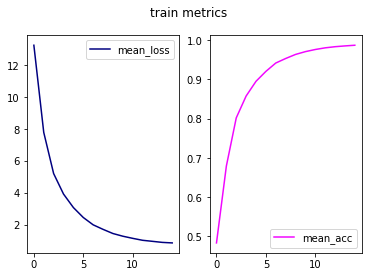

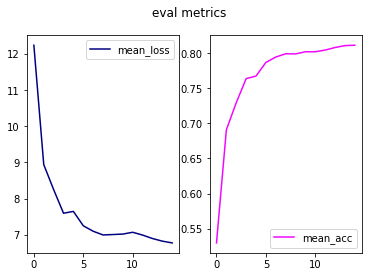

0it [00:00, ?it/s]

In [ ]:
if __name__ == "__main__":
    
    # Setup saving path
    # exp_date = datetime.datetime.strftime(datetime.datetime.now() + datetime.timedelta(hours=1), "%Y_%m_%d_%H_%M_%S")
    save_path_parent = os.path.join(ORIGIN_DATASET_FOLDER, 'results', 'non_pretrained_for_task2')
    os.mkdir(save_path_parent)
    
    params_task1 = {
        "save_path_parent": save_path_parent,
        "epochs": 15,
        "loss": 'weighted_cross_entropy',
        "lr": 3e-4,
        "batch_size": 32,
        "focal_loss_gamma": 2.0,
        "use_scheduler": True
    }
    task1_net, task1_dataset = task1(**params_task1)
    torch.save(task1_net, 'task1_net.pth')


#### Task2

In [ ]:
if __name__ == '__main__':
    # try: _ = save_path_parent
    # except NameError:
    #     exp_date = datetime.datetime.strftime(datetime.datetime.now() + datetime.timedelta(hours=1), "%Y_%m_%d_%H_%M_%S")
    #     save_path_parent = os.path.join("/content/drive/MyDrive/DeepLearningProject/results", exp_date)
    
    # try: _ = task1_dataset
    # except NameError: task1_dataset, _ = get_dataset(ORIGIN_DATASET_FOLDER, 'train')
    
    # try: _ = task1_net
    # except: task1_net = ARModel()
    task1_net = torch.load('task1_net.pth')

    params_task2 = {
        "save_path_parent": save_path_parent,
        "epochs": 10,
        "lr": 2e-5,
        "batch_size": 32,
        "model": None,
        "task1_ids": task1_dataset.get_identities(),
        "lazy_eval": True,
        "use_scheduler": True
    }
    task2_net = task2(**params_task2)

------------- EPOCH 1/10 -------------


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


train : loss = 0.8855211734771729 | accuracy = 0.0

------------- EPOCH 2/10 -------------


0it [00:00, ?it/s]

train : loss = 0.46781906485557556 | accuracy = 0.0

------------- EPOCH 3/10 -------------


0it [00:00, ?it/s]

train : loss = 0.257996529340744 | accuracy = 0.0

------------- EPOCH 4/10 -------------


0it [00:00, ?it/s]

train : loss = 0.17330332100391388 | accuracy = 0.0

------------- EPOCH 5/10 -------------


0it [00:00, ?it/s]

train : loss = 0.14445827901363373 | accuracy = 0.0

------------- EPOCH 6/10 -------------


0it [00:00, ?it/s]

train : loss = 0.11912066489458084 | accuracy = 0.0

------------- EPOCH 7/10 -------------


0it [00:00, ?it/s]

train : loss = 0.10635017603635788 | accuracy = 0.0

------------- EPOCH 8/10 -------------


0it [00:00, ?it/s]

train : loss = 0.09980595856904984 | accuracy = 0.0

------------- EPOCH 9/10 -------------


0it [00:00, ?it/s]

train : loss = 0.08941774815320969 | accuracy = 0.0

------------- EPOCH 10/10 -------------


0it [00:00, ?it/s]

train : loss = 0.08523809164762497 | accuracy = 0.0

---------- final MAP ----------
Preparing valid_set.csv ...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0.2185014277832409
